In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns
sns.set_theme('paper')


## Paramsnet


In [ ]:
# params

# cfg = ExtractConfig(
#     # model="microsoft/phi-2",
#     # # batch_size=1,
#     # prompt_format="phi",
# )
# cfg

# params
batch_size = 32
lr = 4e-3
wd = 0 # 1e-5

MAX_ROWS = 2000

SKIP=5 # skip initial N layers
STRIDE=4 # skip every N layers
DECIMATE=12 # discard N features for speed

device = "cuda:0"
max_epochs = 44

# VAE_EPOCH_MULT = 1
l1_coeff = 1.0e-4  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
    # x_feats=x_feats. other use 1e-1


BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/")
layers_names = ('fc1', 'Wqkv', 'fc2', 'out_proj')

## Load data

In [ ]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

In [ ]:
# insample_datasets = list(set(ds_val['ds_string_base']))
# outsample_datasets = list(set(ds_ood['ds_string_base']))
# print(insample_datasets, outsample_datasets)

In [ ]:
input_columns = ['binary_ans_base', 'binary_ans_adapt' ] + [f'end_residual_{layer}_base' for layer in layers_names] + [f'end_residual_{layer}_adapt' for layer in layers_names]

def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f'end_residual_{layer}_base'], ds[f'end_residual_{layer}_adapt']]
        X1 = rearrange(X1, 'versions b l f  -> b l f versions')
        data.append(X1)
    
    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    y = ds['binary_ans_base']-ds['binary_ans_adapt']
    return dict(X=X, y=y)



def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y
    
    """
    ds = (ds
          .with_format("torch")
          .select_columns(input_columns)
          .map(ds2xy_batched, batched=True, batch_size=128,
        remove_columns=input_columns)
    )
    return ds

def load_file_to_dm(f):
    ds = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds = filter_ds_to_known(ds, verbose=True, true_col='truth')
    ds = prepare_ds(ds)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS*2)
    ds = ds.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=4)
    dm.setup()
    return dm




In [ ]:
dm = load_file_to_dm(f1_val)
dm_ood = load_file_to_dm(f1_ood)

In [ ]:
# slow... takes 12 mins. It's the accessing
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])


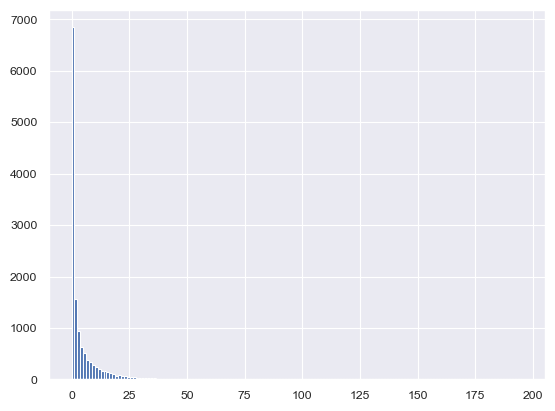

In [96]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[SKIP::STRIDE, ::DECIMATE]
plt.hist(importance_matrix.flatten(), bins=155);


In [ ]:
ds_test2 = dm.datasets['test']
shape1 = ds_test2[0]['X'][:, :, 0].shape
shape2= importance_matrix.shape
np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


# Model

In [ ]:

from src.vae.conv_inception import AutoEncoder, PLAE

# Train

### Metrics


In [ ]:
def get_acc_subset(df, query, verbose=True):
    if query:
        df = df.query(query)
    acc = (df["probe_pred"] == df["y"]).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits["test"]
    df_test = dm.df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred > 0.0

    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits["val"]
        df_val = dm.df.iloc[splits[0] : splits[1]].copy()
        df_val["probe_pred"] = y_val_pred > 0.0

        df_test = pd.concat([df_val, df_test])

    if verbose:
        print("probe results on subsets of the data")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "llm_ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "llm_ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=False
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["instructed_to_lie==False", "instructed_to_lie==True"],
        columns=["llm_ans==label_instructed", "llm_ans!=label_instructed"],
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    d1.index.name = "instructed to"
    d1.columns.name = "llm gave"
    print("probe accuracy for quadrants")
    display(d1.round(2))

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)

### Setup

In [ ]:


print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]


In [ ]:
# # TEST
# for b in tqdm(dl_train):
#     pass

In [ ]:
# %%time
# # oh no, this is very slow
# g = iter(dl_train)
# b = next(g)
# b = next(g)


In [ ]:

net = PLAE(
    c_in=c_in,
    steps_per_epoch=len(dl_train),
    max_epochs=max_epochs,
    lr=lr,
    weight_decay=wd,
    hs=64,
    depth=3,
    dropout=1,
    n_latent=16,
    l1_coeff=l1_coeff, 
    importance_matrix=importance_matrix,
)
print(c_in)
x1= x[..., 0]
with torch.no_grad():
    y = net(x1)
{k: v.abs().mean() for k, v in y.items()}

In [ ]:
from torchinfo import summary

summary(net, input_data=x1, depth=4)  # input_size=(batch_size, 1, 28, 28))


### Train autoencoder

In [ ]:
torch.set_float32_matmul_precision('medium')

In [ ]:
%%time
for b in tqdm(dl_train):
    pass

In [ ]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results

from lightning.pytorch.callbacks import LearningRateMonitor

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 1.3 M 
1 | head | Sequential  | 16.1 K
-------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.160     Total estimated model params size (MB)


training ae
requires_grad: True


Training: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:747: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


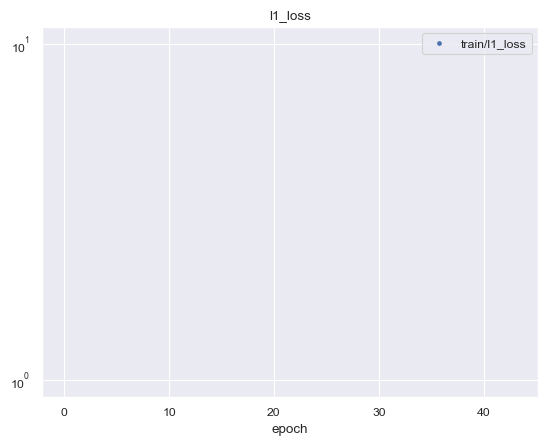

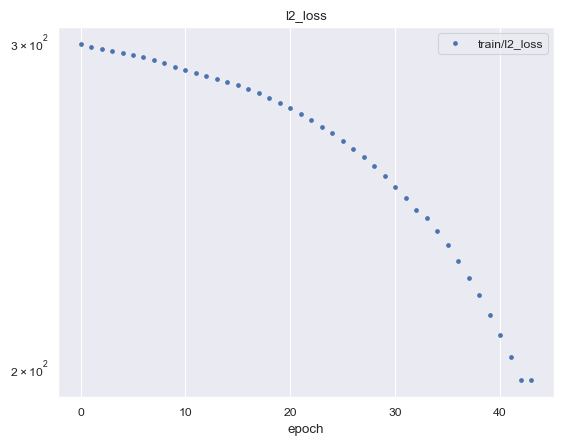

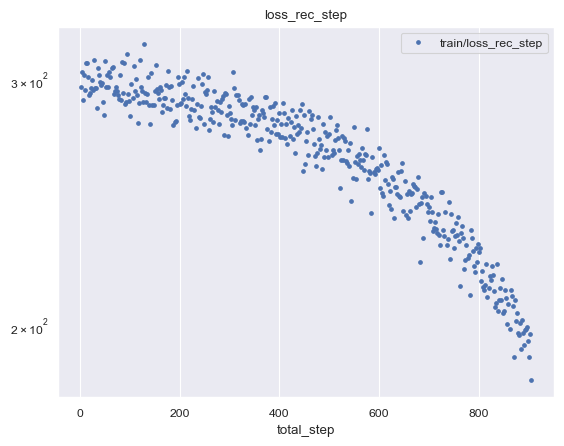

,train/loss_rec_step,lr-AdamW,step,train/loss_pred_step,train/n,train/auroc,train/l1_loss,train/loss_rec_epoch,train/acc,train/loss_pred_epoch,train/l2_loss
epoch,,,,,,,,,,,
0.0,293.195831,0.000161,10,0.692220,307.0,0.5,0.0,299.265808,0.615635,0.688221,299.265808
1.0,298.423737,0.000162,20,0.685151,307.0,0.5,0.0,298.280945,0.615635,0.688221,298.280945
2.0,301.166016,0.000165,30,0.689863,307.0,0.5,0.0,297.448639,0.615635,0.688221,297.448639
3.0,289.801666,0.000169,40,0.687507,307.0,0.5,0.0,296.673370,0.615635,0.688221,296.673370
4.0,297.535065,0.000174,50,0.685151,307.0,0.5,0.0,296.101410,0.615635,0.688221,296.101410
5.0,294.063690,0.000180,60,0.682794,307.0,0.5,0.0,295.280914,0.615635,0.688221,295.280914
6.0,287.579926,0.000187,70,0.699288,307.0,0.5,0.0,294.320190,0.615635,0.688221,294.320190
7.0,287.725311,0.000195,80,0.694576,307.0,0.5,0.0,293.272522,0.615635,0.688221,293.272522
8.0,278.412384,0.000205,90,0.704001,307.0,0.5,0.0,292.141510,0.615635,0.688221,292.141510


In [97]:
net.ae_mode(0)
 
lr_logger = LearningRateMonitor(logging_interval='step')
trainer1 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    # devices=2,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs,# * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
    callbacks=[lr_logger],
)

# LOAD_CHECKPONT = Path('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
LOAD_CHECKPONT = None
if LOAD_CHECKPONT:
    PLAE.load_from_checkpoint(LOAD_CHECKPONT)
else:
    trainer1.fit(model=net, train_dataloaders=dl_train, 
                #  val_dataloaders=dl_val # FIXME why does this slow it down with multiple processes?
                );

    df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
    plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=True)
    plt.show()
    plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

    display(df_hist)


<Axes: xlabel='epoch'>

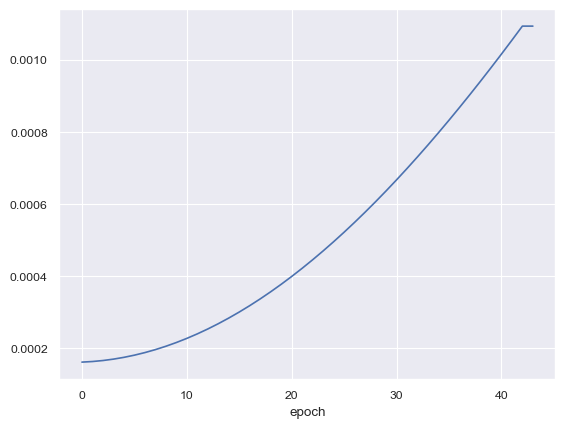

In [98]:
# Check the LR
df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
df_hist['lr-AdamW'].plot()

<Axes: >

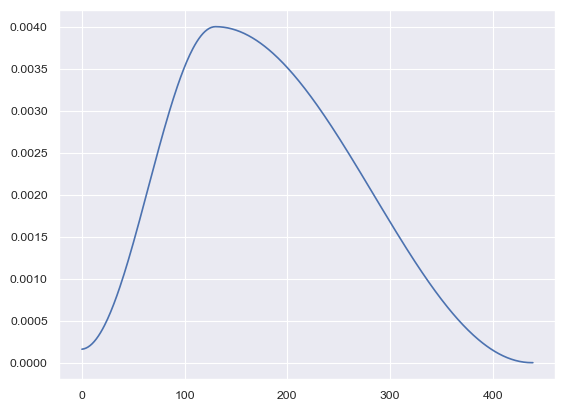

In [100]:
s = net.configure_optimizers()[1][0]
total_steps = net.hparams.steps_per_epoch * net.hparams.max_epochs
data = []
for i in range(total_steps):
    s.step()
    l_rate = s.get_last_lr()[0]
    data.append(l_rate)
    # if i % 100 == 0:
    #     print(l_rate)

pd.Series(data).plot()

5/10 [00:04<00:04, 1.10it/s, v_num=295, val/loss_pred=0.0849, val/loss_rec=9.58e+5, train/loss_pred=0.350, train/loss_rec=9.8e+5]


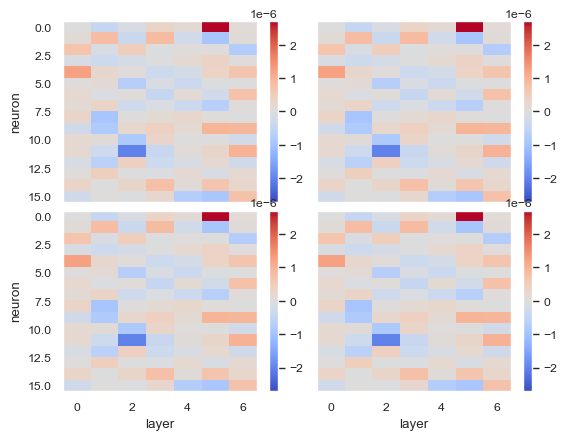

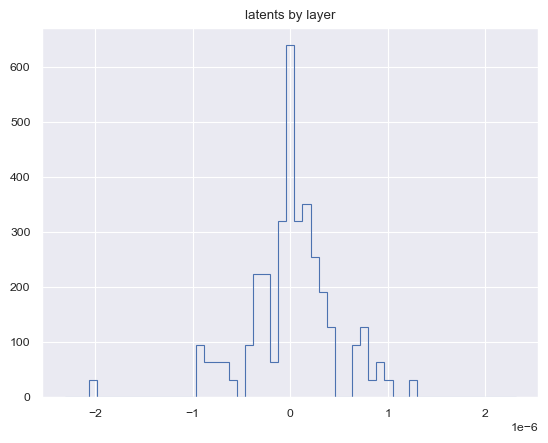

In [101]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):

    # plot image of latent space
    vmax = latent.abs().max()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].abs().max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xlabel("layer")
        plt.ylabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b n l -> (b n) l").flatten()
    vmax = (latentf.abs().mean() + 5 * latentf.abs().std()).item()
    plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype="step")
    plt.title("latents by layer")
    plt.show()


latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)


In [ ]:
latent.shape, latent.diff(dim=1).std(), latent.std(), latent.diff(dim=2).std(), 16*7

### Train probe

In [103]:
# # net.save_checkpoint
# f = Path(trainer1.log_dir)/"1_ae.ckpt"
# trainer1.save_checkpoint(f)
# # PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
# f

In [104]:
# net.configure_optimizers()

In [105]:
# debug
with torch.no_grad():
    b = next(iter(dl_train))
    y = net.predict_step(b)

In [106]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
    callbacks=[lr_logger],
)
trainer2.fit(model=net, train_dataloaders=dl_train, 
            #  val_dataloaders=dl_val
             );


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 1.3 M 
1 | head | Sequential  | 16.1 K
-------------------------------------
16.1 K    Trainable params
1.3 M     Non-trainable params
1.3 M 

training probe
requires_grad: False


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred_epoch', 'acc'])
df_hist

In [ ]:

# predict


# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])




In [ ]:
testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]

#### how well does it generalize to other datasets?


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer1, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs


### Train end-to-end


In [ ]:
net.ae_mode(2)
trainer3 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer3.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer3.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

# predict
# dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer3.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])

testval_metrics = calc_metrics(dm, trainer3, net, use_val=True)
rs = rename_pl_test_results(rs, ["train", "val", "test", "ood"])
# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]


In [ ]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer3.test(net, dataloaders=[dl_ood])
rs2 = rename_pl_test_results(rs2, ks=["ood"])

testval_metrics2 = calc_metrics(dm_ood, trainer3, net, use_val=True)
rs["ood"]["acc_lie_lie"] = testval_metrics2["acc_lie_lie"]
rs["ood_metrics"] = rs2["ood"]
rs
